<a href="https://colab.research.google.com/github/livlutz/INF1608-Projeto/blob/colab-test/pendulo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF1608 - Análise Numérica
## Projeto: **Movimento de um Pêndulo**
### Integrantes:


*   Daniel Stulberg Huf (1920468)
*   Lívia Lutz dos Santos (2211055)
*   Pedro Gonçalves Mannarino (2210617)

---



## **Descrição**

Considere um pêndulo simples como o mostrado na figura. O corpo de peso $W$ está preso a uma haste sem peso de comprimento $l$. As únicas forças atuantes no corpo são seu peso e a tensão $R$ na haste. A posição do corpo em qualquer instante é expressa pelo ângulo $θ$. A equação diferencial de segunda ordem que rege o movimento do pêndulo é:

$$
\ddot{\theta} + \frac{g}{l} \sin{\theta} = 0
$$

onde $g$ representa a aceleração da gravidade. A solução desta equação exige o uso de um método numérico.

Se considerarmos que $θ$ é pequeno, podemos aproximar $\sin{\theta} \approx \theta$, e então ficamos com a equação diferencial:

$$
\ddot{\theta} + \frac{g}{l} \theta = 0
$$

Esta equação simplificada tem solução analítica simples:

$$
\theta(t) = \theta_0 \cos{\left( \sqrt{\frac{g}{l}} t \right)}
$$

Neste caso, o período (tempo necessário para o pêndulo completar um ciclo) é dado por:

$$
T = 2\pi \sqrt{\frac{l}{g}}
$$

<p align="center">
  <br>
  <img src="https://drive.google.com/uc?export=view&id=1GGCq7xNCBldygPFvV2BFlpEZeyAz3SBT" width="200"/>
</p>

---

## **Tarefa**

O objetivo deste trabalho é usar o método Runge-Kutta de ordem 4, *com passo adaptativo*, para resolver a equação diferencial original e comparar os resultados com os obtidos através da simplificação de linearização da expressão. Deve-se usar passo adaptativo, limitando o erro local de cada passo em $\epsilon = 10^{-5}$. Pode-se usar a estratégia de dobrar o passo ou usar o método acoplado de Runge-Kutta para avaliar o erro. Numa primeira etapa, deve-se usar passo constante para validação do sistema.

Para diferentes valores de $\theta_0$, plote o gráfico de $\theta \times t$ de um ciclo completo, considerando a solução numérica e a solução analítica aproximada. Calcule também o valor do período $T$ do ciclo. Confirme que a solução simplificada só é uma boa aproximação para ângulos pequenos.

Para calcular numericamente o valor do período, pode-se monitorar a mudança de sinal da velocidade. Por exemplo, se no tempo $t_1$ a velocidade for $v_1$ e no tempo $t_2$ a velocidade for $v_2$ com $v_1 \cdot v_2 \leq 0$, então o período pode ser estimado por interpolação linear:

$$
T = 2 \left[ t_1 + \frac{|v_1|}{|v_1| + |v_2|}(t_2 - t_1) \right]
$$

Para aumentar a precisão, pode-se medir o tempo da, por exemplo, décima inversão da velocidade, e calcular o tempo de dez períodos, e então achar o tempo de um período.

---


## Análise

Ao desenvolver seu trabalho e testá-lo, procure, baseado em experimentos computacionais, responder às seguintes perguntas:

- Faça um comparativo do valor do período calculado e do número de passos, para diferentes ângulos iniciais $\theta_0$:
  - Considerando a solução analítica simplificada
  - Considerando um passo constante: $h = 0.01$
  - Considerando um passo constante: $h = 0.001$
  - Considerando um passo constante: $h = 0.0001$
  - Considerando o uso de passo adaptativo

- Baseado no seu experimento, qual o ângulo inicial $\theta_0$ máximo para que a fórmula simplificada reporte um período com erro menor que 0.001?

- Qual o tempo de execução da simulação para 10 períodos considerando as diferentes estratégias de passo listadas no item do quadro comparativo?

- Seu sistema executa em tempo real? Isto é, você itera o sistema em tempo físico menor que o passo de integração usado?

---

## Desenvolvimento

O código para resolução da tarefa e posterior análise está mostrado abaixo.


In [ ]:
# Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

In [ ]:
# Parâmetros globais

g = 9.81            # aceleração da gravidade (m/s²)
l = 1.0             # comprimento da haste (m)
epsilon = 1e-5      # tolerância para passo adaptativo

In [ ]:
# Funções

def edo_pendulo(t, y):
    """Equação diferencial do pêndulo"""
    theta, theta_dot = y
    return np.array([theta_dot, -g / l * np.sin(theta)])


def passo_rk4(f, t, y, h):
    """Um passo do método Runge-Kutta de ordem 4"""
    k0 = h * f(t, y)
    k1 = h * f(t + h / 2, y + k0 / 2)
    k2 = h * f(t + h / 2, y + k1 / 2)
    k3 = h * f(t + h, y + k2)
    return y + (k0 + 2 * k1 + 2 * k2 + k3) / 6


def passo_adaptativo(f, t, y, h):
    """Passo adaptativo usando a estratégia de dobrar o passo"""
    # Um passo de tamanho h
    y_1 = passo_rk4(f, t, y, h)

    # Dois passos de tamanho h/2
    h2 = h / 2.0
    y_m = passo_rk4(f, t, y, h2)
    y_2 = passo_rk4(f, t + h2, y_m, h2)

    # Estimativa do erro
    delta = (y_1 - y_2) / 15.0
    erro_y2 = np.max(np.abs(delta))

    # Fator de ajuste
    if erro_y2 > 1e-12:
        f = (epsilon / erro_y2) ** (1.0 / 5.0)
    else:
        f = 2.0

    # Decisão de aceitação
    if f >= 1.0:
        # Aceita o passo
        y_resultado = y_2 + delta
        h_novo = h * min(1.2, f)
        return y_resultado, h_novo, True
    else:
        # Rejeita o passo
        h_novo = h * 0.8 * f
        return y, h_novo, False


def solucao_adaptativa(theta0, t_max, h_init=0.01):
    """Resolve usando passo adaptativo"""
    t = 0.0
    y = np.array([theta0, 0.0])
    h = h_init

    tempos = [t]
    solucoes = [y.copy()]

    while t < t_max:
        if t + h > t_max:
            h = t_max - t

        y_novo, h_novo, aceito = passo_adaptativo(edo_pendulo, t, y, h)

        if aceito:
            t += h
            y = y_novo
            tempos.append(t)
            solucoes.append(y.copy())
            h = h_novo
        else:
            h = h_novo

    return np.array(tempos), np.array(solucoes)


def solucao_constante(theta0, t_max, h):
    """Resolve usando passo constante"""
    n_passos = int(t_max / h) + 1
    tempos = np.linspace(0, t_max, n_passos)
    solucoes = np.zeros((n_passos, 2))
    solucoes[0] = [theta0, 0.0]

    for i in range(1, n_passos):
        solucoes[i] = passo_rk4(edo_pendulo, tempos[i - 1], solucoes[i - 1], h)

    return tempos, solucoes


def solucao_analitica(theta0, t):
    """Solução analítica simplificada (pequenos ângulos)"""
    omega = np.sqrt(g / l)
    return theta0 * np.cos(omega * t)


def calcular_periodo_numerico(tempos, solucoes):
    """Calcula o período numericamente usando mudança de sinal da velocidade"""
    theta_dot = solucoes[:, 1]

    # Procura por mudanças de sinal na velocidade
    mudancas_sinal = []
    for i in range(1, len(theta_dot)):
        if theta_dot[i - 1] * theta_dot[i] <= 0:
            # Interpolação linear para encontrar o zero
            t1, t2 = tempos[i - 1], tempos[i]
            v1, v2 = theta_dot[i - 1], theta_dot[i]

            if abs(v1) + abs(v2) > 1e-12:  # Evita divisão por zero
                t_zero = t1 + abs(v1) / (abs(v1) + abs(v2)) * (t2 - t1)
                mudancas_sinal.append(t_zero)

    # Tenta usar múltiplos períodos para maior precisão
    # Para N períodos completos, precisamos de 2*N+1 mudanças de sinal
    if len(mudancas_sinal) >= 21:  # 10 períodos completos
        tempo_total = mudancas_sinal[20] - mudancas_sinal[0]
        periodo_medio = tempo_total / 10
        return periodo_medio
    elif len(mudancas_sinal) >= 11:  # 5 períodos completos
        tempo_total = mudancas_sinal[10] - mudancas_sinal[0]
        periodo_medio = tempo_total / 5
        return periodo_medio
    elif len(mudancas_sinal) >= 5:  # 2 períodos completos
        tempo_total = mudancas_sinal[4] - mudancas_sinal[0]
        periodo_medio = tempo_total / 2
        return periodo_medio
    elif len(mudancas_sinal) >= 2:
        return 2 * (mudancas_sinal[1] - mudancas_sinal[0])
    else:
        return float("nan")


def calcular_periodo_analitico():
    """Período analítico da aproximação linear"""
    return 2 * np.pi * np.sqrt(l / g)


def analise_comparativa():
    """Executa análise comparativa para diferentes ângulos iniciais"""

    # Ângulos iniciais para testar (em radianos)
    angulos_iniciais = [5, 10, 15, 30, 45, 60, 90]
    valores_angulos = [np.deg2rad(deg) for deg in angulos_iniciais]

    # Estratégias de passo
    estrategias = {
        "Analítica": None,
        "h=0.01": 0.01,
        "h=0.001": 0.001,
        "h=0.0001": 0.0001,
        "Adaptativo": "adaptive",
    }

    print("=== ANÁLISE COMPARATIVA DO PÊNDULO SIMPLES ===\n")

    periodo_analitico = calcular_periodo_analitico()

    dados = []

    for theta0, theta0_deg in zip(valores_angulos, angulos_iniciais):
        # Calcula período para um ciclo completo
        t_max = 1.5 * periodo_analitico  # um pouco mais que um período

        for nome_estrategia, tamanho_passo in estrategias.items():
            start_time = time.time()

            if nome_estrategia == "Analítica":
                periodo = periodo_analitico
                n_passos = 0
                erro_percentual = 0.0

            elif nome_estrategia == "Adaptativo":
                tempos, solucoes = solucao_adaptativa(theta0, t_max)
                periodo = calcular_periodo_numerico(tempos, solucoes)
                n_passos = len(tempos)
                erro_percentual = abs(periodo - periodo_analitico) / periodo_analitico * 100

            else:
                tempos, solucoes = solucao_constante(theta0, t_max, tamanho_passo)
                periodo = calcular_periodo_numerico(tempos, solucoes)
                n_passos = len(tempos)
                erro_percentual = abs(periodo - periodo_analitico) / periodo_analitico * 100

            tempo_execucao = time.time() - start_time

            dados.append(
                {
                    "Ângulo (°)": theta0_deg,
                    "Estratégia": nome_estrategia,
                    "Período (s)": periodo,
                    "Erro (%)": erro_percentual,
                    "N° Passos": n_passos,
                    "Tempo (s)": tempo_execucao,
                }
            )

    df = pd.DataFrame(dados)

    pd.set_option("display.precision", 6)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    pd.set_option("display.max_colwidth", None)

    print(
        df.to_string(
            index=False,
            formatters={
                "Período (s)": "{:.6f}".format,
                "Erro (%)": "{:.3f}".format,
                "Tempo (s)": "{:.6f}".format,
            },
        )
    )


def plotar_comparacao(theta0_deg=30):
    """Plota comparação entre solução numérica e analítica"""

    theta0 = np.deg2rad(theta0_deg)
    periodo_analitico = calcular_periodo_analitico()
    t_max = periodo_analitico  # um período completo

    # Solução numérica (passo adaptativo)
    tempos_num, solucoes_num = solucao_adaptativa(theta0, t_max)
    theta_num = solucoes_num[:, 0]

    # Solução analítica
    tempos_ana = np.linspace(0, t_max, 1000)
    theta_ana = solucao_analitica(theta0, tempos_ana)

    # Plota comparação
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(
        tempos_ana, np.rad2deg(theta_ana), "b-", label="Solução Analítica (aprox.)", linewidth=2
    )
    plt.plot(
        tempos_num,
        np.rad2deg(theta_num),
        "r--",
        label="Solução Numérica (RK4)",
        linewidth=2,
        alpha=0.8,
    )
    plt.xlabel("Tempo (s)")
    plt.ylabel("Ângulo (°)")
    plt.title(f"Comparação das Soluções - Ângulo Inicial: {theta0_deg}°")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 1, 2)
    # Interpola solução numérica para os mesmos tempos da analítica
    theta_num_interp = np.interp(tempos_ana, tempos_num, theta_num)
    error = np.rad2deg(np.abs(theta_num_interp - theta_ana))
    plt.plot(tempos_ana, error, "g-", linewidth=2)
    plt.xlabel("Tempo (s)")
    plt.ylabel("Erro Absoluto (°)")
    plt.title("Erro entre Solução Numérica e Analítica")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calcula período numérico
    periodo_num = calcular_periodo_numerico(tempos_num, solucoes_num)
    print(f"\nResultados para ângulo inicial {theta0_deg}°:")
    print(f"Período analítico: {periodo_analitico:.6f} s")
    print(f"Período numérico: {periodo_num:.6f} s")
    print(f"Erro relativo: {abs(periodo_num - periodo_analitico)/periodo_analitico*100:.3f}%")


def encontrar_angulo_maximo_para_erro_menor_que_0_1():
    """Encontra o ângulo máximo para erro < 0.1% no período"""

    periodo_analitico = calcular_periodo_analitico()

    print("\n=== ANÁLISE DE ÂNGULO MÁXIMO PARA ERRO < 0.1% ===")

    dados = []
    angulo_maximo = 0

    for theta0_deg in range(1, 91, 1):
        theta0 = np.deg2rad(theta0_deg)
        t_max = 1.5 * periodo_analitico

        tempos, solucoes = solucao_adaptativa(theta0, t_max)
        periodo_num = calcular_periodo_numerico(tempos, solucoes)

        if not np.isnan(periodo_num):
            erro_percentual = abs(periodo_num - periodo_analitico) / periodo_analitico * 100

            dados.append(
                {
                    "Ângulo (°)": theta0_deg,
                    "Período Num (s)": periodo_num,
                    "Erro (%)": erro_percentual,
                }
            )

            if erro_percentual < 0.1:
                angulo_maximo = theta0_deg
            else:
                break

    df = pd.DataFrame(dados)
    print(
        df.to_string(
            index=False,
            formatters={"Período Num (s)": "{:.6f}".format, "Erro (%)": "{:.3f}".format},
        )
    )

    print(f"\nÂngulo máximo para erro < 0.1%: {angulo_maximo}°")
    return angulo_maximo


def analisar_tempo_de_execucao(theta=30, n=10):
    """Analisa tempo de execução para n períodos e ângulo inicial theta"""

    theta0 = np.deg2rad(theta)
    periodo_analitico = calcular_periodo_analitico()
    t_max = n * periodo_analitico

    estrategias = {"h=0.01": 0.01, "h=0.001": 0.001, "h=0.0001": 0.0001, "Adaptativo": "adaptive"}

    print(f"\n=== ANÁLISE DE TEMPO DE EXECUÇÃO ({n} PERÍODOS, θ₀={theta}°) ===")

    dados = []

    for nome_estrategia, tamanho_passo in estrategias.items():
        start_time = time.time()

        if nome_estrategia == "Adaptativo":
            tempos, solucoes = solucao_adaptativa(theta0, t_max)
        else:
            tempos, solucoes = solucao_constante(theta0, t_max, tamanho_passo)

        tempo_execucao = time.time() - start_time
        n_passos = len(tempos)

        # Verifica se executa em tempo real
        real_time = tempo_execucao < t_max
        real_time_str = "Sim" if real_time else "Não"

        # Calcula erro do período
        periodo_num = calcular_periodo_numerico(tempos, solucoes)

        if not np.isnan(periodo_num):
            erro = abs(periodo_num - periodo_analitico) / periodo_analitico * 100
        else:
            erro = float("nan")

        dados.append(
            {
                "Estratégia": nome_estrategia,
                "Tempo (s)": tempo_execucao,
                "N° Passos": n_passos,
                "Tempo Real?": real_time_str,
                "Erro (%)": erro
            }
        )

    df = pd.DataFrame(dados)
    print(
        df.to_string(
            index=False, formatters={"Tempo (s)": "{:.6f}".format, "Erro (%)": "{:.3f}".format}
        )
    )

---

## Testes

Os testes de execução do trabalho para responder às perguntas estão mostrados abaixo.


In [ ]:
analise_comparativa()

=== ANÁLISE COMPARATIVA DO PÊNDULO SIMPLES ===

 Ângulo (°) Estratégia Período (s) Erro (%)  N° Passos Tempo (s)
          5  Analítica    2.006067    0.000          0  0.000001
          5     h=0.01    2.013110    0.351        301  0.015399
          5    h=0.001    2.007089    0.051       3010  0.205993
          5   h=0.0001    2.007022    0.048      30092  2.506341
          5 Adaptativo    2.005340    0.036         29  0.007415
         10  Analítica    2.006067    0.000          0  0.000001
         10     h=0.01    2.015989    0.495        301  0.016516
         10    h=0.001    2.009959    0.194       3010  0.208790
         10   h=0.0001    2.009893    0.191      30092  3.538387
         10 Adaptativo    2.009813    0.187         31  0.019014
         15  Analítica    2.006067    0.000          0  0.000001
         15     h=0.01    2.020805    0.735        301  0.054096
         15    h=0.001    2.014761    0.433       3010  0.807984
         15   h=0.0001    2.014694    0.43


Gráficos de comparação


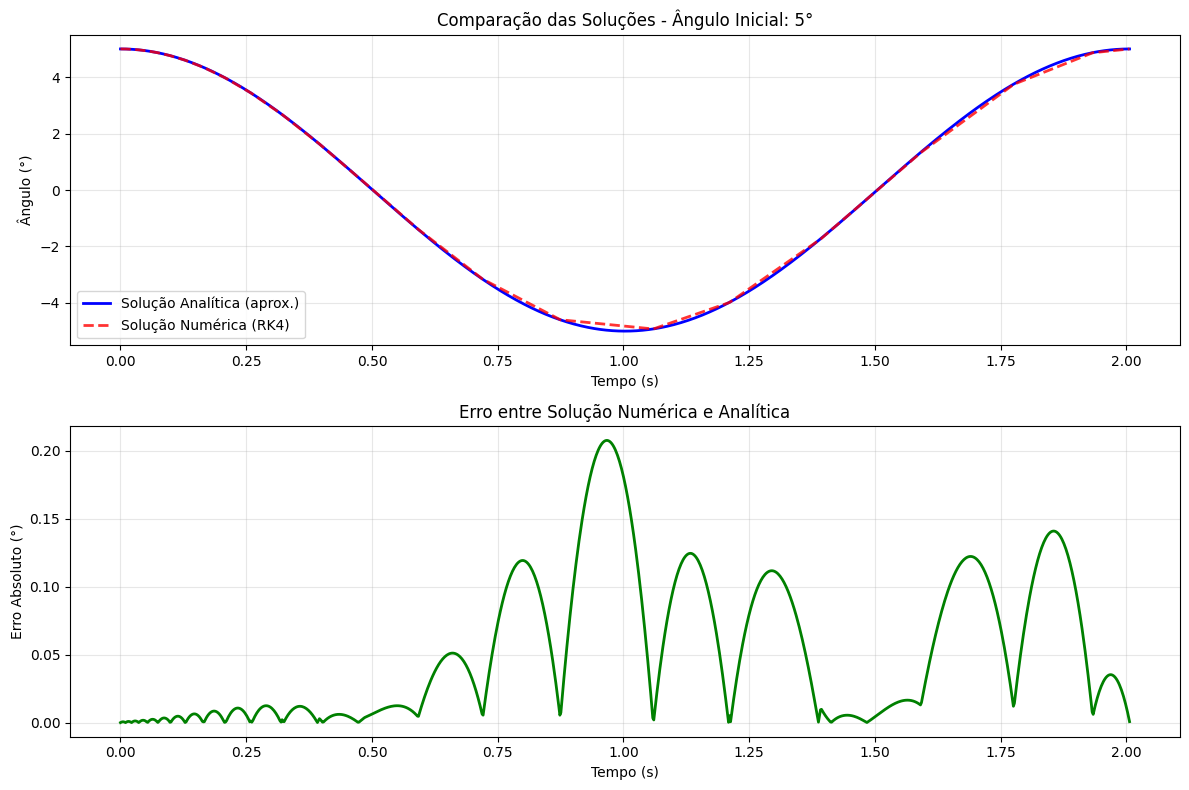


Resultados para ângulo inicial 5°:
Período analítico: 2.006067 s
Período numérico: 2.005340 s
Erro relativo: 0.036%


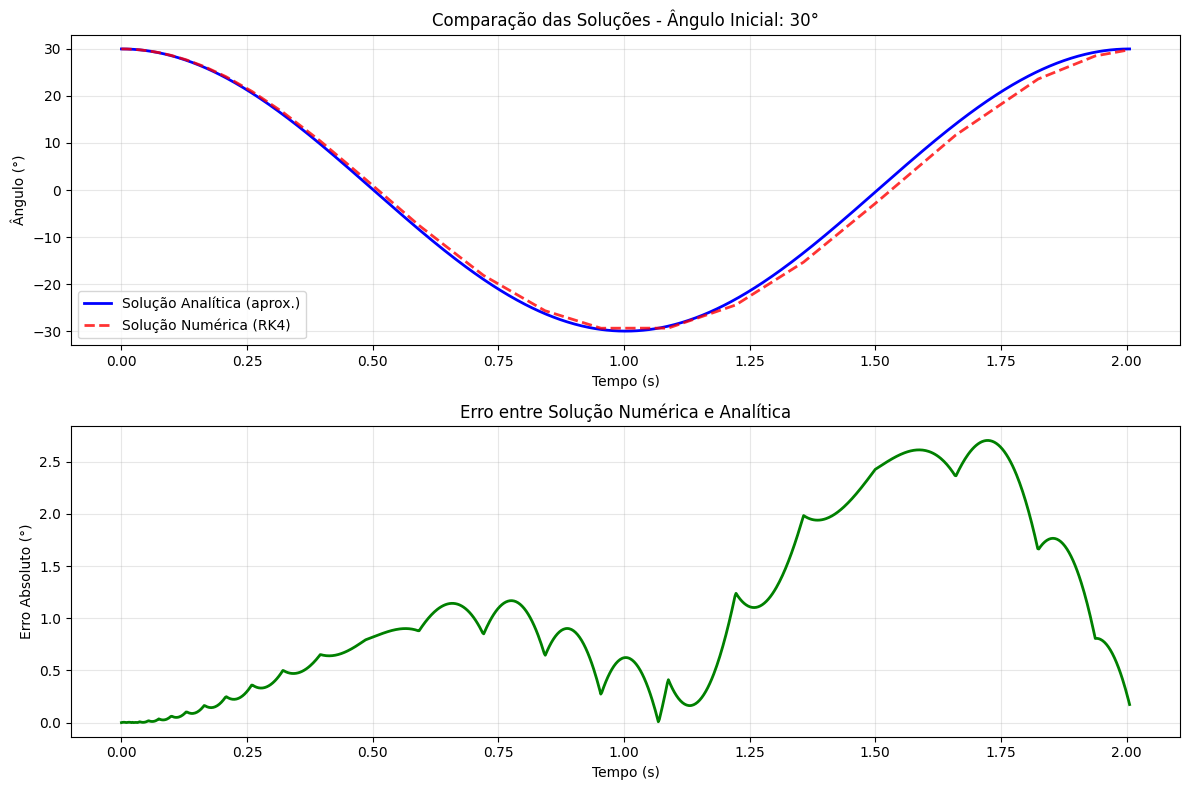


Resultados para ângulo inicial 30°:
Período analítico: 2.006067 s
Período numérico: 2.041025 s
Erro relativo: 1.743%


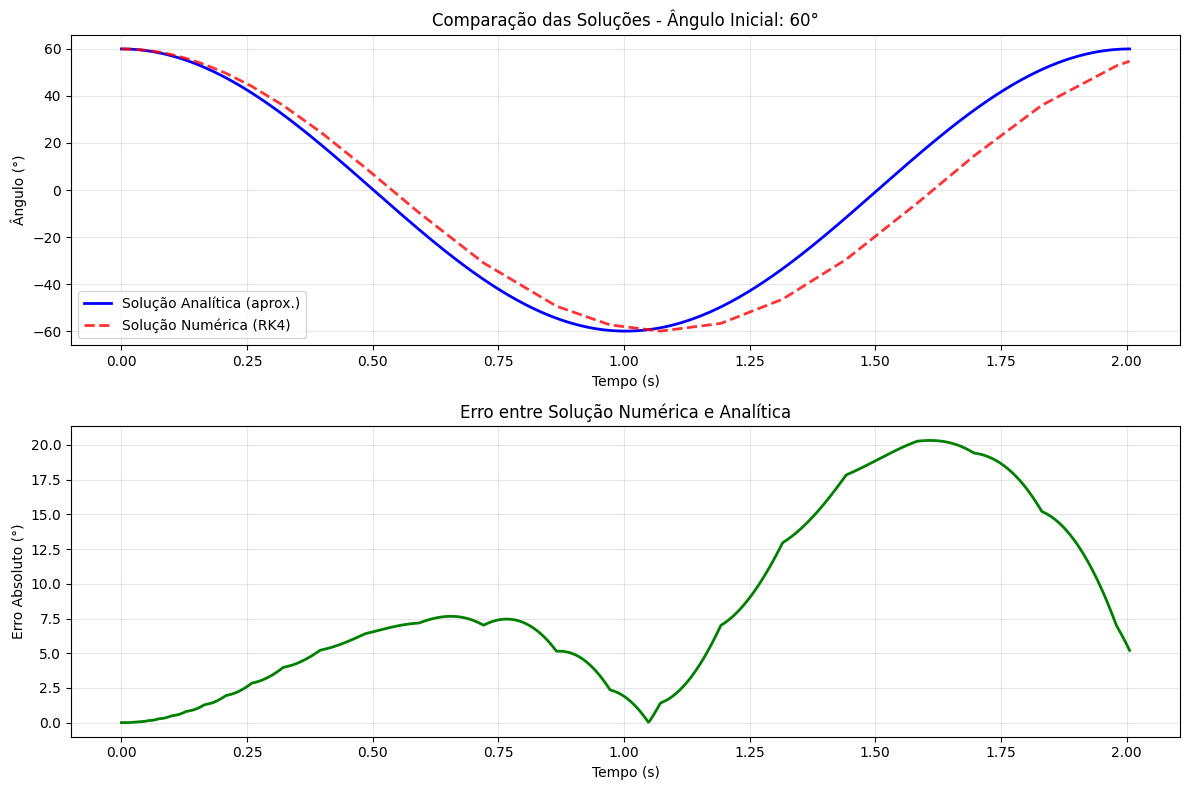


Resultados para ângulo inicial 60°:
Período analítico: 2.006067 s
Período numérico: 2.152977 s
Erro relativo: 7.323%


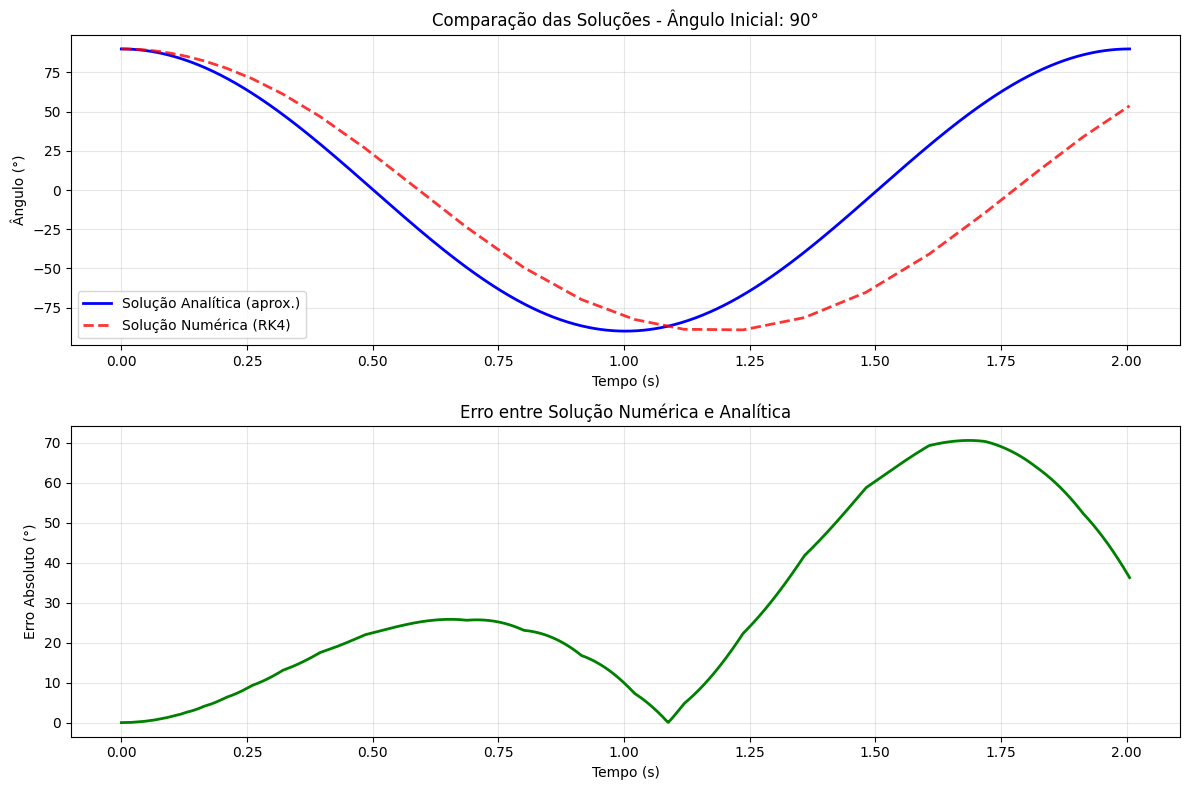


Resultados para ângulo inicial 90°:
Período analítico: 2.006067 s
Período numérico: 2.367848 s
Erro relativo: 18.034%


In [ ]:
print("\nGráficos de comparação")
for angle in [5, 30, 60, 90]:
    plotar_comparacao(angle)

In [ ]:
angulo_maximo = encontrar_angulo_maximo_para_erro_menor_que_0_1()


=== ANÁLISE DE ÂNGULO MÁXIMO PARA ERRO < 0.1% ===
 Ângulo (°) Período Num (s) Erro (%)
          1        2.004431    0.082
          2        2.004545    0.076
          3        2.004734    0.066
          4        2.004999    0.053
          5        2.005340    0.036
          6        2.006656    0.029
          7        2.007347    0.064
          8        2.008102    0.101

Ângulo máximo para erro < 0.1%: 7°


In [ ]:
analisar_tempo_de_execucao(90, 10)
analisar_tempo_de_execucao(90, 20)
analisar_tempo_de_execucao(90, 30)
analisar_tempo_de_execucao(90, 40)
analisar_tempo_de_execucao(90, 50)
analisar_tempo_de_execucao(90, 60)
analisar_tempo_de_execucao(90, 70)
analisar_tempo_de_execucao(90, 80)
analisar_tempo_de_execucao(90, 90)
analisar_tempo_de_execucao(90, 100)


=== ANÁLISE DE TEMPO DE EXECUÇÃO (10 PERÍODOS, θ₀=90°) ===
Estratégia Tempo (s)  N° Passos Tempo Real? Erro (%)
    h=0.01  0.076655       2007         Sim   18.038
   h=0.001  0.640894      20061         Sim   18.038
  h=0.0001  7.352925     200607         Sim   18.034
Adaptativo  0.028677        190         Sim   18.034

=== ANÁLISE DE TEMPO DE EXECUÇÃO (20 PERÍODOS, θ₀=90°) ===
Estratégia Tempo (s)  N° Passos Tempo Real? Erro (%)
    h=0.01  0.115337       4013         Sim   18.038
   h=0.001  1.189802      40122         Sim   18.035
  h=0.0001 12.740510     401214         Sim   18.034
Adaptativo  0.049628        370         Sim   18.033

=== ANÁLISE DE TEMPO DE EXECUÇÃO (30 PERÍODOS, θ₀=90°) ===
Estratégia Tempo (s)  N° Passos Tempo Real? Erro (%)
    h=0.01  0.171197       6019         Sim   18.038
   h=0.001  1.820990      60183         Sim   18.034
  h=0.0001 20.064517     601821         Sim   18.034
Adaptativo  0.073906        550         Sim   18.033

=== ANÁLISE DE TEMPO DE 

---